<a target="_blank" href="https://colab.research.google.com/github.com/sayakpaul/TF-2.0-Hacks/blob/master/NALU%20in%20TF%202.0/NALU_using_TF_2_0.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

In [ ]:
# Install the latest GPU version
%%bash
pip install tensorflow-gpu==2.0.0-beta0

In [1]:
# Imports
import tensorflow as tf
from utils import generate_data
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta0


I will start off by writing a custom layer for incorporating the operations of the NAC unit as specified in the paper. I will also customize the way the layer would do a forward pass. 

In [ ]:
# Neural Accumulator
class NAC_Layer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(NAC_Layer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    shape = [int(input_shape[-1]), self.num_outputs]
    self.W_hat = self.add_variable("W_hat",
                                    shape=shape, initializer=tf.initializers.GlorotUniform())

    self.M_hat = self.add_variable("M_hat",
                                    shape=shape, initializer=tf.initializers.GlorotUniform())

  def call(self, x):
    W = tf.nn.tanh(self.W_hat) * tf.nn.sigmoid(self.M_hat)
    return tf.matmul(x, tf.cast(W, 'float64'))

### Rough inspection on the data with `NAC`

Now that I have defined the `NAC` unit, I will use it to see how it performs on toy data. For that, I will generate some and I am going to use addition operation to generate the targets. 

`generate_data(20, 30, 10000, '+')` function will 
- generate 10000 2D datapoints within the range [20, 30]
- perform addition over them and return the results

In [ ]:
# Define the train/test sets
op = '+'
X_train, y_train = generate_data(20, 30, 10000, op)
X_test, y_test = generate_data(10, 40, 7000, op)

I made sure that the test datapoints are outside the range of the training datapoints. 

In [15]:
# Define a NAC layer with the output shape
nac_layer = NAC_Layer(1)
# Supply the input shape
pred = nac_layer(X_train)
pred.dtype

tf.float64

In [16]:
# How does the values look like?
tf.squeeze(pred)[:10]

<tf.Tensor: id=41, shape=(10,), dtype=float64, numpy=
array([2.63298306, 3.1526201 , 2.04053661, 2.82519872, 1.94385148,
       2.0920834 , 1.33643436, 1.94657931, 3.07839541, 2.83097707])>

The predictions do not tell you anything. They are results of only forward pass through the NAC unit. Let's now train NAC. 

In [ ]:
# Loss function to optimize and how to optimize
loss_func = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr=0.01)

I will now define how the layer parameters should get updated - **backprop** only. The `tf.function` decorator converts a Python function to a TensorFlow compatible graph.  

In [ ]:
# Train the model
@tf.function
def model_train(features, labels, layer):
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        # Get the predictions
        predictions = layer(features)
        # Calculate the loss
        loss = loss_func(labels, tf.squeeze(predictions))
    # Get the gradients
    gradients = tape.gradient(loss, layer.trainable_variables)
    # Update the weights
    optimizer.apply_gradients(zip(gradients, layer.trainable_variables))
   
    return loss

In [ ]:
# Validating the model
@tf.function
def model_validate(features, labels, layer):
    predictions = layer(features)
    loss = loss_func(labels, tf.squeeze(predictions))
    return loss, predictions

We are all set. I will now write a helper function which would train and validate the training process. 

In [ ]:
def train_and_validate(X_train, y_train, 
                       X_test, y_test,layer):
  total_train_loss = []
  total_validation_loss = []
  print('First ten targets in the test set:\n')
  print(y_test[:10])
  
  for i in range(1, 10000+1):
      train_loss = model_train(X_train, y_train, layer)
      val_loss, predictions = model_validate(X_test, y_test, layer)

      if i%1000==0:
          template = '\nEpoch {}, train_loss: {}, validation_loss: {}'
          print (template.format(i,
                                 train_loss,
                                 val_loss))
          print('\nTargets after epoch {}\n'.format(i))
          print(tf.squeeze(predictions)[:10])
          print('\n')

      total_train_loss.append(train_loss)
      total_validation_loss.append(val_loss)
      
  return total_train_loss, total_validation_loss

And a neat plot to depict the training and validation loss after the training. 

In [ ]:
def plot_losses(total_train_loss, total_validation_loss, title):
  plt.plot(np.log(total_train_loss))
  plt.plot(np.log(total_validation_loss))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend(['Train_Loss', 'Test_Loss'])
  plt.show()

I start by using the NAC layer on the addition operation. I train the layer for 10000 epochs. 

In [22]:
total_train_loss, total_validation_loss = \
                  train_and_validate(X_train, y_train, X_test, y_test, nac_layer)

First ten targets in the test set:

[50.89833592 69.94461125 65.40791562 44.17026785 63.78794738 75.92558239
 54.37208909 52.00315269 27.31983737 50.26042119]

Epoch 1000, train_loss: 9.471661567687988, validation_loss: 9.938295364379883

Targets after epoch 1000

tf.Tensor(
[47.80724283 65.65043007 61.42859611 41.47131585 59.87081273 71.26874066
 50.97568896 48.83763191 25.65706424 47.20863896], shape=(10,), dtype=float64)



Epoch 2000, train_loss: 2.660127639770508, validation_loss: 2.793597936630249

Targets after epoch 2000

tf.Tensor(
[49.2485112  67.66901287 63.28649854 42.7355455  61.71248214 73.45621904
 52.59257302 50.31618804 26.43363315 48.63137715], shape=(10,), dtype=float64)



Epoch 3000, train_loss: 1.1519583463668823, validation_loss: 1.2101085186004639

Targets after epoch 3000

tf.Tensor(
[49.8096403  68.44721214 64.00866652 43.22501786 62.42232587 74.30026869
 53.20642514 50.89061829 26.73537439 49.18538642], shape=(10,), dtype=float64)



Epoch 4000, train_loss: 0

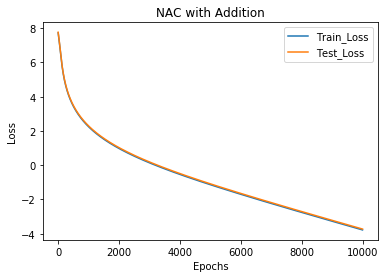

In [23]:
plot_losses(total_train_loss, total_validation_loss, 'NAC with Addition')

Now it's time to implement NALU. NALU builds on top of NAC and I am going to use the NAC_Layer class I defined earlier. 

In [ ]:
# Neural Arithmetic Logic Unit
class NALU_Layer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(NALU_Layer, self).__init__()
    self.num_outputs = num_outputs
    self.nac = NAC_Layer(self.num_outputs)
    self.eps = 1e-7

  def build(self, input_shape):
    shape = [int(input_shape[-1]), self.num_outputs]
    self.G = self.add_variable("G",
                                    shape=shape, initializer=tf.initializers.GlorotUniform())

  def call(self, x):
    g = tf.nn.sigmoid(tf.matmul(x, self.G))
    y1 = g * self.nac(x)
    y2 = (1 - g) * tf.exp(self.nac(tf.math.log(tf.abs(x) + self.eps)))
    return y1 + y2

But to test the effectivity of NALU, I am going to generate data for multiplication and division operations. 

In [ ]:
# Define the train/test sets
op = '*'
X_train, y_train = generate_data(20, 30, 10000, op)
X_test, y_test = generate_data(10, 40, 7000, op)

In [32]:
# Define the outshape
nalu_layer = NALU_Layer(1)
# Supply the input shape
pred = nalu_layer(X_train)
pred.shape

TensorShape([10000, 1])

> Remember to rerun `model_train()` and `model_validate()` before running the following because those two functions are decorated with `tf.function` which constructs a graph of the training ops. To know more about `tf.function` and `AutoGraph` refer [here](https://www.tensorflow.org/beta/guide/autograph). 

In [33]:
total_train_loss, total_validation_loss = \
                  train_and_validate(X_train, y_train, X_test, y_test, nalu_layer)

First ten targets in the test set:

[ 759.85438978  483.93778667  567.53468376  445.83780586 1107.10372011
  860.54357056  206.14978166  453.79483664  992.9294036  1298.39925451]

Epoch 1000, train_loss: 543.0645751953125, validation_loss: 730.666748046875

Targets after epoch 1000

tf.Tensor(
[ 733.60303681  466.96842583  549.69162405  429.18183148 1063.682947
  825.8310084   200.04953614  437.98999869  951.91330291 1244.57258668], shape=(10,), dtype=float64)



Epoch 2000, train_loss: 194.71409606933594, validation_loss: 262.32421875

Targets after epoch 2000

tf.Tensor(
[ 744.13004383  473.77761871  556.85009592  435.86498001 1081.08180596
  839.74354846  202.50096471  444.33257831  968.34772736 1266.13259009], shape=(10,), dtype=float64)



Epoch 3000, train_loss: 94.07832336425781, validation_loss: 126.8096694946289

Targets after epoch 3000

tf.Tensor(
[ 748.92280745  476.87603987  560.10760642  438.90638535 1089.00965479
  846.08183569  203.6148112   447.21838561  975.83697782 1

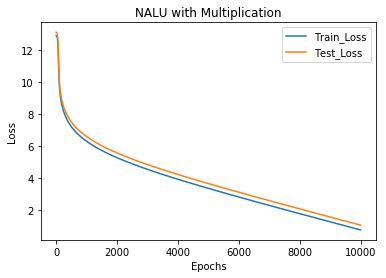

In [34]:
plot_losses(total_train_loss, total_validation_loss, 'NALU with Multiplication')

Looks good. Let's now do it for division. 

In [ ]:
# Define the train/test sets
op = '/'
X_train, y_train = generate_data(20, 30, 10000, op)
X_test, y_test = generate_data(10, 40, 7000, op)

> Remember to rerun `model_train()` and `model_validate()` before running the following because those two functions are decorated with `tf.function` which constructs a graph of the training ops. To know more about `tf.function` and `AutoGraph` refer [here](https://www.tensorflow.org/beta/guide/autograph). 

In [39]:
total_train_loss, total_validation_loss = \
                  train_and_validate(X_train, y_train, X_test, y_test, nalu_layer)

First ten targets in the test set:

[1.38301664 1.09116424 0.47851288 1.78905664 1.31470231 0.65025846
 0.73410272 3.32974004 2.48348736 0.72528226]

Epoch 1000, train_loss: 8.48122501373291, validation_loss: 7.79790735244751

Targets after epoch 1000

tf.Tensor(
[3.99477667 2.96260608 3.55295447 3.7456087  4.12056879 3.08333583
 4.33013072 3.90459824 3.39747532 3.42041312], shape=(10,), dtype=float64)



Epoch 2000, train_loss: 2.557645082473755, validation_loss: 2.408573627471924

Targets after epoch 2000

tf.Tensor(
[2.65252448 2.14352915 2.4045999  2.54531374 2.70872138 2.18725973
 2.78003857 2.64519414 2.3888879  2.35609074], shape=(10,), dtype=float64)



Epoch 3000, train_loss: 0.9149757623672485, validation_loss: 0.9972195029258728

Targets after epoch 3000

tf.Tensor(
[1.99100042 1.70893412 1.83075935 1.94132292 2.01902967 1.72058945
 2.03918379 2.01213578 1.86556077 1.81549329], shape=(10,), dtype=float64)



Epoch 4000, train_loss: 0.33248546719551086, validation_loss: 0.542

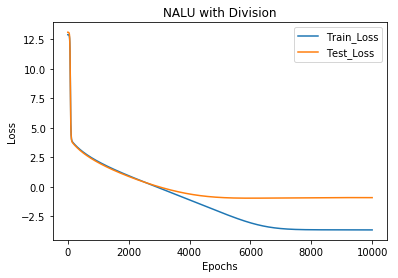

In [40]:
plot_losses(total_train_loss, total_validation_loss, 'NALU with Division')

As explored in the paper also, the network struggles to converge for operations like division, exponentiation and so on. 